# Metaphor Extraction and Classification:

In this Notebook you can find all the methods used to identify, extract and classify conceptual metaphors about inflation.

The methods are:
- Regex
- Part of Speech
- Neural Network
- Large Language Model 

In [ ]:
#!pip install ecbdata

In [9]:
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from textblob import TextBlob
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
from ecbdata import ecbdata

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer 
from nltk.stem import WordNetLemmatizer

nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
warnings.filterwarnings('ignore')

import spacy
sp = spacy.load('en_core_web_sm')

tqdm.pandas()

porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

#ECB Color
color = (17/255, 49/255, 147/255)

# File containing the functions
from src.Metaphor_Detection_Functions import *

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\School\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\School\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Regex

**Basic Regex:**

To find the conceptual metaphors mentioning "Inflation", we will try to find sentences which contains the word "Inflation" followed or preceeded by any word from a corpus given by the paper: Inflation Metaphor in Contemporary American English.

The corpus contains the 9 roots mentioned in the paper. 

**Choice between Stemming or Lemmatization:**

Stemming: Stemming is generally faster and simpler than lemmatization, but it may not always produce a valid word since it applies simple rules to chop off suffixes. In your case, stemming could potentially match "beat" with "beating" but may produce incorrect results in some cases.

Lemmatization: Lemmatization, on the other hand, maps words to their base or dictionary form, which is more linguistically accurate. It typically requires more computational resources compared to stemming but can provide more accurate results

Select modulation for this notebook:

In [10]:
# mod = 0 means just lowercase, mod = 1 means stemming, mod = 2 means lemmatizing
mod_regex = 2

# Target words:
words_to_match = ["inflation","deflation","inflationary","desinflationary","hyperinflation","disinflation"]

In [7]:
# Import dataset containing the interveiw data
df = pd.read_csv('Data/Final_Data.csv')

# Convert 'date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

print("Shape of the dataset before dropping missing values: ", df.shape)
df.isna().sum()
print("Shape of the dataset after dropping missing values: ", df.shape)
df.nunique()


Shape of the dataset before dropping missing values:  (519, 30)
Shape of the dataset after dropping missing values:  (519, 30)


Unnamed: 0                519
Date                      489
Media                     259
Member                     19
Link                      519
Information               361
Questions                 465
Answers                   509
Metaphors                  59
Metaphors Sentence         59
YoB                        15
Gender                      2
Country                    10
Period on the Board        14
list_regex                407
list_regex_reduced        407
list_regex_len             38
list_regex_reduced_len     38
text_length               504
pos_metaphors             177
pos_metaphors_len          15
Sentences                 406
Frequency                  43
Sentences_len              35
Sentence_GPT_Majority     406
GPT_Majority_Category     308
Matched_Metaphors          60
pos_relationships         307
pos_sentences             242
pos_relationships_len      28
dtype: int64

In [8]:
start = df["Date"].min()
start = start.strftime('%Y-%m')
df2 = ecbdata.get_series('ICP.M.U2.N.000000.4.ANR', 
                        start=start)
df2["TIME_PERIOD"] = pd.to_datetime(df2["TIME_PERIOD"])
print("Start date is: ",start)

Start date is:  2005-01


In [9]:
# List of words to match: (Mix of words from the paper and other sources (e.g. ChatGPT))
as_plant = ['hedge', 'nip', 'bloom', 'sprout', 'grow', 'blossom', 'flower', 'bush', 'shrub', 'leaf', 'petal', 'stem', 'root', 'thorn', 'thistle', 'fern', 'moss', 'ivy', 'vine', 'creeper', 'branch', 'twig', 'sapling', 'seedling', 'trunk', 'foliage', 'lush', 'verdant', 'botany', 'flora', 'pollen', 'nectar', 'pollinate', 'photosynthesis', 'chlorophyll', 'garden', 'orchard', 'nursery', 'weed', 'weedkiller', 'prune', 'trim', 'mulch', 'compost', 'fertilize', 'transplant', 'perennial', 'annual', 'deciduous', 'evergreen', 'shade', 'sunlight', 'water', 'nutrients', 'soil', 'arid', 'drought', 'flood', 'tendril', 'mushroom', 'cactus', 'succulent', 'bark', 'pine', 'oak', 'maple', 'palm', 'lily', 'rose', 'daisy', 'tulip', 'daffodil', 'carnation', 'lawn', 'sod', 'bulb', 'cypress', 'fir', 'ginkgo', 'juniper', 'magnolia', 'willow', 'thistle', 'lilac', 'orchid', 'poppy', 'violet', 'dandelion', 'clover']
as_animal = ['roar', 'pounce', 'stalk', 'attack', 'bite', 'claw', 'snarl', 'charge', 'hunt', 'intimidate', 'defend', 'rend', 'tear', 'dominate', 'fangs', 'claws', 'aggression', 'predation', 'territoriality', 'hackles', 'mane', 'prowess', 'strength', 'ferocity', 'dominance', 'menace', 'threat', 'piercing', 'glaring', 'talons', 'paws', 'beak', 'scales', 'horns', 'tusks', 'quills', 'tail', 'jaws', 'muzzle', 'fierce', 'intimidating', 'savage', 'menacing', 'aggressive', 'predatory', 'dominant', 'territorial', 'formidable', 'ruthless', 'daunting', 'wild', 'ferocious', 'hissing', 'prey', 'teeth', 'savage', 'feral', 'voracious', 'primal', 'untamed', 'predatory', 'beastly', 'wild', 'barbarous', 'fierce', 'wolf', 'leopard', 'snake', 'shark', 'eagle', 'feathers', 'bear', 'bull', 'lion', 'sharp', 'span']
as_liquids = ['erode', 'surge', 'subside', 'simmers', 'emergence', 'ebb', 'dilute', 'spurt', 'recede', 'buoy', 'flow', 'pour', 'drip', 'splash', 'ripple', 'stream', 'trickle', 'cascade', 'gush', 'drain', 'seep', 'soak', 'flood', 'ooze', 'swirl', 'pool', 'droplet', 'melt', 'evaporate', 'condense', 'vaporize', 'liquefy', 'freeze', 'thaw', 'spray', 'mist', 'fountain', 'wave', 'current', 'whirlpool', 'whirl', 'eddy', 'torrent', 'deluge', 'overflow', 'percolate', 'absorb', 'douse', 'immerse', 'saturate', 'slosh', 'quench', 'hydrate', 'teem', 'aquatic', 'viscous', 'fluid', 'liquidation', 'solution', 'solvent', 'moisture', 'hydration', 'reservoir', 'aquifer', 'spring', 'well', 'creek', 'river', 'lake', 'pond', 'ocean', 'sea', 'bay', 'delta', 'waterfall', 'rapids', 'canal', 'channel', 'estuary', 'lagoon', 'fjord', 'gulf', 'marsh', 'swamp', 'bog', 'wetland', 'mud', 'slime', 'silt', 'sediment', 'brine', 'oil', 'gasoline', 'alcohol', 'juice', 'soda', 'milk', 'coffee', 'tea', 'soup']
as_fire = ['ignite', 'fuel', 'spark', 'dampen', 'stoke', 'kindle', 'choke', 'stifle', 'fan', 'flare-up', 'douse', 'snuff', 'blaze', 'burn', 'combust', 'flame', 'inferno', 'smolder', 'char', 'embers', 'ash', 'heat', 'bonfire', 'campfire', 'wildfire', 'arson', 'firefighter', 'fireproof', 'firebreak', 'firewood', 'fireplace', 'firestorm', 'firefighting', 'fireman', 'firetruck', 'firehouse', 'flint', 'match', 'lighter', 'torch', 'camping', 'smoke', 'smokestack', 'soot', 'scorched', 'scorching', 'singe', 'conflagration', 'incendiary', 'pyre', 'safety', 'extinguish', 'hose', 'hydrant', 'alarm', 'evacuate', 'emergency', 'inferno', 'combustion', 'heatwave', 'smoke detector', 'fire blanket', 'fire escape', 'fire prevention', 'fire drill', 'firecracker', 'fireworks', 'fire brigade', 'fire marshal', 'fire trail', 'fire station', 'fire pit', 'fireworks display', 'smoke alarm', 'fire-retardant']
as_disease = ['plague', 'worsen', 'benign', 'virulent', 'debilitate', 'bout', 'chronically', 'illness', 'sickness', 'infection', 'malady', 'ailment', 'condition', 'syndrome', 'disorder', 'pathogen', 'virus', 'bacteria', 'parasite', 'fungus', 'contagion', 'epidemic', 'pandemic', 'outbreak', 'transmission', 'spread', 'symptoms', 'fever', 'cough', 'cold', 'flu', 'fatigue', 'weakness', 'nausea', 'vomiting', 'diarrhea', 'headache', 'muscle', 'pain', 'aches', 'chills', 'rash', 'inflammation', 'swelling', 'lesion', 'ulcer', 'scar', 'tumor', 'cancer', 'metastasis', 'diagnosis', 'treatment', 'therapy', 'medication', 'prescription', 'antibiotic', 'antiviral', 'antifungal', 'antibacterial', 'immunization', 'vaccination', 'immunity', 'immune', 'response', 'resistance', 'susceptibility', 'prevention', 'control', 'management', 'prognosis', 'recovery', 'remission', 'relapse', 'complication', 'morbidity', 'mortality', 'patient', 'doctor', 'nurse', 'hospital', 'clinic', 'emergency', 'ward', 'ICU', 'intensive care', 'healthcare', 'public health', 'epidemiology', 'palliative', 'care', 'hospice', 'quarantine', 'isolation']
as_warfare = ['threat', 'subdue', 'target', 'beat', 'preempt', 'vigilant', 'ravage', 'undermine', 'forestall', 'counteract', 'eliminate', 'ferocious', 'ruinous', 'clobber', 'buster', 'eradicate', 'besieged', 'thwart', 'bash', 'beset', 'combat', 'conflict', 'battle', 'war', 'fight', 'engagement', 'skirmish', 'confrontation', 'hostilities', 'assault', 'offensive', 'defense', 'siege', 'ambush', 'raid', 'invasion', 'occupation', 'conquest', 'resistance', 'surrender', 'victory', 'defeat', 'truce', 'ceasefire', 'armistice', 'escalation', 'deescalation', 'escalate', 'deescalate', 'strategy', 'tactics', 'battlefield', 'frontline', 'troops', 'soldiers', 'military', 'army', 'navy', 'airforce', 'marines', 'commander', 'general', 'officer', 'captain', 'sergeant', 'private', 'weapon', 'firearm', 'ammunition', 'bomb', 'missile', 'tank', 'artillery', 'aircraft', 'warship', 'submarine', 'helicopter', 'drone', 'grenade', 'explosive', 'grenade launcher', 'mine', 'landmine', 'grenade', 'bayonet', 'rifle', 'machine gun', 'sniper', 'artillery', 'barrage', 'bombardment', 'naval', 'air', 'ground', 'infantry', 'cavalry', 'special forces', 'guerrilla', 'insurgent', 'terrorist', 'paramilitary', 'mercenary']
as_sports = ['pace', 'outstrip', 'lag', 'surpass', 'quicken', 'outrun', 'bout', 'best', 'tug-of-war', 'zip', 'overtake', 'athletics', 'competition', 'game', 'match', 'tournament', 'contest', 'event', 'race', 'contestant', 'athlete', 'player', 'team', 'coach', 'referee', 'umpire', 'spectator', 'fan', 'supporter', 'stadium', 'arena', 'field', 'court', 'pitch', 'track', 'course', 'rink', 'ring', 'gymnasium', 'arena', 'field', 'court', 'pitch', 'track', 'course', 'rink', 'ring', 'gymnasium', 'training', 'practice', 'warm-up', 'stretching', 'conditioning', 'exercise', 'regimen', 'drill', 'workout', 'routine', 'warm-up', 'stretching', 'conditioning', 'exercise', 'regimen', 'drill', 'workout', 'routine', 'skill', 'technique', 'strategy', 'tactics', 'formation', 'play', 'move', 'pass', 'shoot', 'score', 'goal', 'point', 'touchdown', 'field goal', 'home run', 'strike', 'spare', 'winner', 'champion', 'victory', 'defeat', 'loss', 'tie', 'draw', 'league', 'division', 'conference', 'championship', 'medal', 'trophy', 'cup', 'prize', 'award', 'record', 'achievement', 'personal best', 'world record', 'fanfare', 'celebration', 'cheer', 'applause', 'ovation', 'boo', 'jeer', 'heckle', 'penalty', 'foul', 'infringement', 'violation', 'suspension', 'ejection', 'injury', 'concussion', 'recovery', 'rehabilitation', 'comeback', 'retirement', 'retirement', 'honor', 'hall of fame', 'legacy', 'heritage']
as_machine = ['accelerate', 'faster', 'control', 'slow', 'trigger', 'skyrocket', 'rapid', 'heat', 'escalate', 'decelerate', 'ratchet', 'unchecked', 'readjusted', 'chug', 'damper', 'zoom', 'mechanism', 'device', 'apparatus', 'equipment', 'tool', 'instrument', 'contraption', 'gadget', 'appliance', 'machine', 'engine', 'motor', 'generator', 'robot', 'robotics', 'automation', 'mechanical', 'electronic', 'hydraulic', 'pneumatic', 'gear', 'lever', 'switch', 'button', 'dial', 'knob', 'control panel', 'interface', 'circuit', 'sensor', 'detector', 'monitor', 'display', 'screen', 'dashboard', 'console', 'keyboard', 'mouse', 'joystick', 'controller', 'remote', 'program', 'software', 'hardware', 'firmware', 'algorithm', 'code', 'data', 'input', 'output', 'processing', 'memory', 'storage', 'transmission', 'communication', 'network', 'connectivity', 'wireless', 'wired', 'interface', 'interface', 'plug', 'socket', 'port', 'connector', 'adapter', 'cable', 'wire', 'electricity', 'power', 'energy', 'current', 'voltage', 'resistance', 'circuitry', 'circuit board', 'microprocessor', 'microcontroller', 'chip', 'component', 'part', 'assembly', 'maintenance', 'repair', 'service', 'upgrade', 'modification', 'installation', 'operation', 'function', 'performance', 'efficiency', 'reliability', 'durability', 'safety', 'security']
as_orientation = ['low', 'rise', 'high', 'increase', 'reduce', 'decline', 'fall', 'exceed', 'spiral', 'hyper', 'upward', 'uptick', 'boost', 'peak', 'diminish', 'upturn', 'hike', 'plummet', 'upswing', 'elevate', 'ascend', 'ascendancy', 'descendancy', 'progress', 'regress', 'advance', 'retreat', 'downward', 'incline', 'decline', 'descent', 'climb', 'drop', 'escalate', 'deescalate', 'soar', 'plunge', 'surge', 'dip', 'slump', 'peak', 'trough', 'crest', 'valley', 'mount', 'sink', 'ascent', 'gain', 'loss', 'progression', 'regression', 'motion', 'movement', 'forward', 'backward', 'onward', 'trend', 'trajectory', 'direction', 'orientation', 'course', 'path', 'route', 'track', 'road', 'way', 'journey', 'voyage', 'migration', 'flow', 'flux', 'shift', 'change', 'variation', 'alteration', 'transition', 'conversion', 'transformation']

as_words = as_fire + as_liquids + as_plant + as_animal + as_disease + as_warfare + as_sports + as_machine + as_orientation
print("Length of the list of words to match: ", len(as_words))
as_words = tokenize_word_list(as_words, mod_regex) # With lemmatization for regex matching
df = preprocess_text_regex(df, mod_regex)

Length of the list of words to match:  853


100%|██████████| 519/519 [03:11<00:00,  2.71it/s]


### Regular Expressions Matcher

In [11]:
# This adds the list of sentences containing the words to match in a new column
regex_match = (df.Answers_cleaned.apply(lambda x: regex_matcher(x, as_words, words_to_match)))
df["list_regex"] = regex_match

# Reduced regex matcher
regex_match = (df.Answers_cleaned.apply(lambda x: regex_matcher_word_order(x, as_words, words_to_match)))
df["list_regex_reduced"] = regex_match

df['list_regex_len'] = df['list_regex'].apply(len)
df['list_regex_reduced_len'] = df['list_regex_reduced'].apply(len)
df['text_length'] = df['Answers'].apply(get_length)

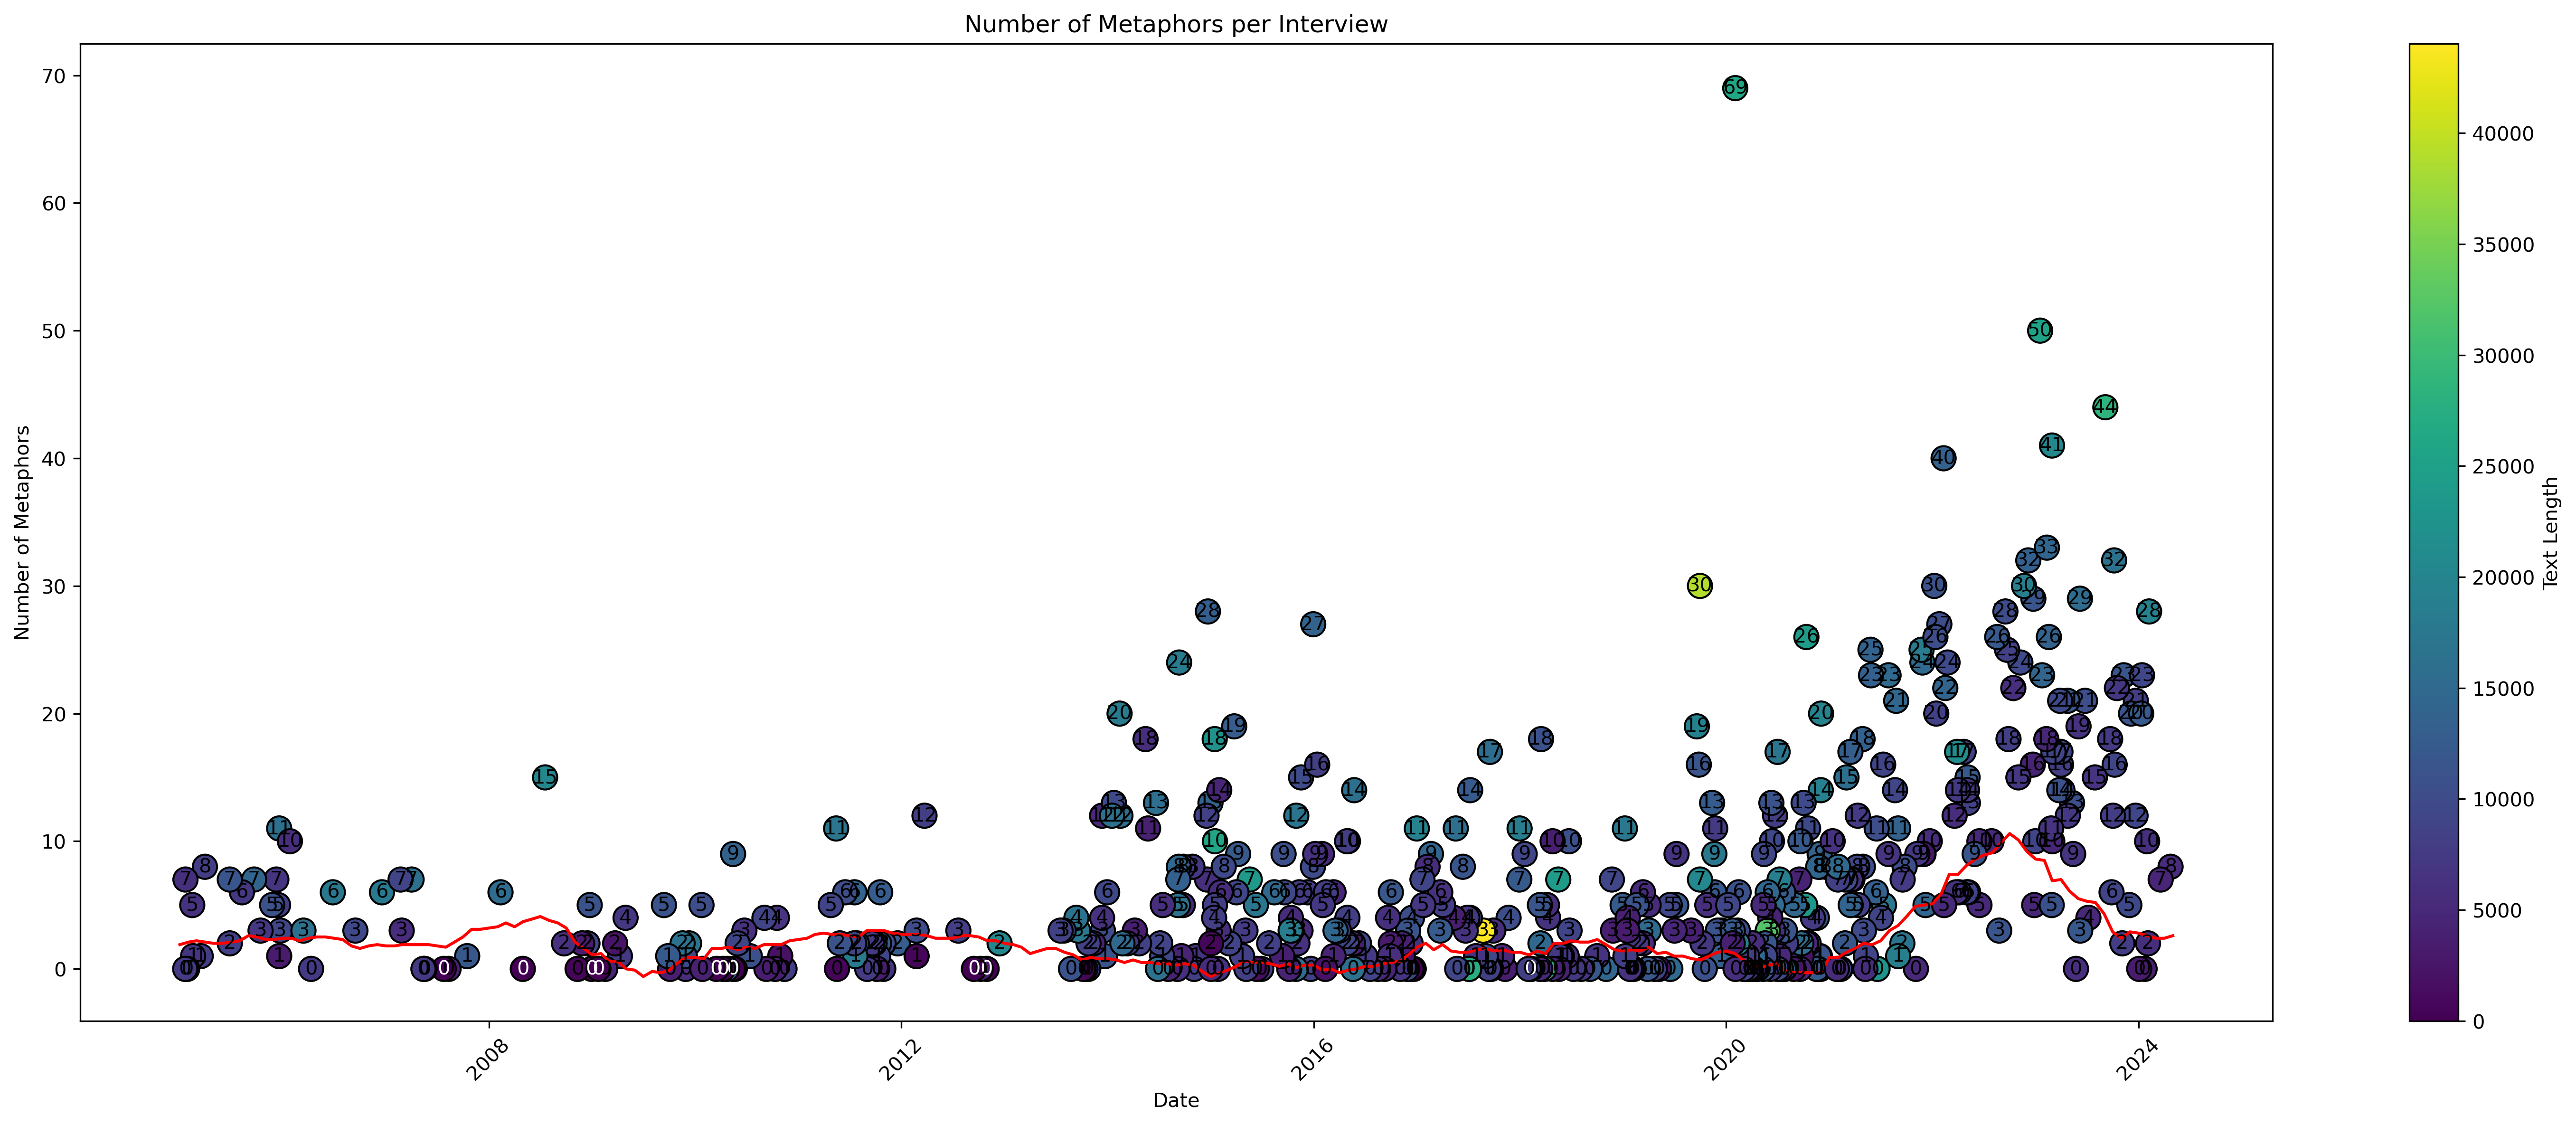

In [20]:
# Defining colors based on text length
norm = mcolors.Normalize(vmin=df['text_length'].min(), vmax=df['text_length'].max())
cmap = plt.cm.get_cmap('viridis')

# Create figure and axes
fig, ax = plt.subplots(figsize=(20, 8), dpi=300)

# Create scatter plot
sc = ax.scatter(df['Date'], df['list_regex_len'], c=df['text_length'], cmap=cmap, norm=norm, s=150, edgecolors='k')

# Add text length colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(df['text_length'])  # Set array to be the range of the colormap
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Text Length')

# Add metaphor count labels inside the points
for i, row in df.iterrows():
    ax.text(row['Date'], row['list_regex_len'], str(row['list_regex_len']), ha='center', va='center', color='white' if row['text_length'] < 0.5 else 'black')

# Plot line for OBS_VALUE from df2
ax.plot(df2['TIME_PERIOD'], df2['OBS_VALUE'], color='red', label='OBS_VALUE')

# Set plot labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Number of Metaphors')
ax.set_title('Number of Metaphors per Interview')

# Rotate x-axis labels for better readability
ax.tick_params(axis='x', rotation=45)

# Show plot
plt.tight_layout()
plt.show()

In [21]:
"""# Save the dataframe
df = df.drop(columns=['Answers_cleaned'])
df.to_csv("Final_Data.csv", index=False)"""

'# Save the dataframe\ndf = df.drop(columns=[\'Answers_cleaned\'])\ndf.to_csv("Final_Data.csv", index=False)'

# Part of Speech (POS)

Use POS to keep only specific adjective-noun, verb-object and subject-verb relationships focusing on "inflation" as noun.

In [ ]:
# mod = 0 means just lowercase, mod = 1 means stemming, mod = 2 means lemmatizing
mod_pos = 0

# Target words:
words_to_match = ["inflation","deflation","inflationary","desinflationary","hyperinflation","disinflation"]

In [24]:
# Import dataset containing the interveiw data
df = pd.read_csv('Data/Final_Data.csv')

# Convert 'date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

df.head()

as_words = as_fire + as_liquids + as_plant + as_animal + as_disease + as_warfare + as_sports + as_machine + as_orientation
print("Length of the list of words to match: ", len(as_words))


as_words = tokenize_word_list(as_words, mod_pos) # Without any pruning for pos tagging
# Depending on the modulation, the list of words to match will be different, remove the duplicates
unique_words = remove_duplicates(as_words)
df = preprocess_text_pos(df, words_to_match, True)

Length of the list of words to match:  853
Unique words: 795


100%|██████████| 519/519 [02:04<00:00,  4.15it/s]


In [25]:
df["pos_metaphors"] = df["pos_relationships"].apply(lambda relationships: find_metaphors_in_relationships(relationships, as_words))
df["pos_metaphors"]

0                                                     []
1                                                     []
2               [(low, inflation), (current, inflation)]
3                                                     []
4                                                     []
                             ...                        
514    [(inflation, fight), (inflation, reduce), (ris...
515                                                   []
516    [(core, inflation), (high, inflation), (high, ...
517    [(inflation, fall), (inflation, ease), (inflat...
518                                                   []
Name: pos_metaphors, Length: 519, dtype: object

In [26]:
df['pos_metaphors_len'] = df['pos_metaphors'].apply(len)
df['pos_relationships_len'] = df['pos_relationships'].apply(len)

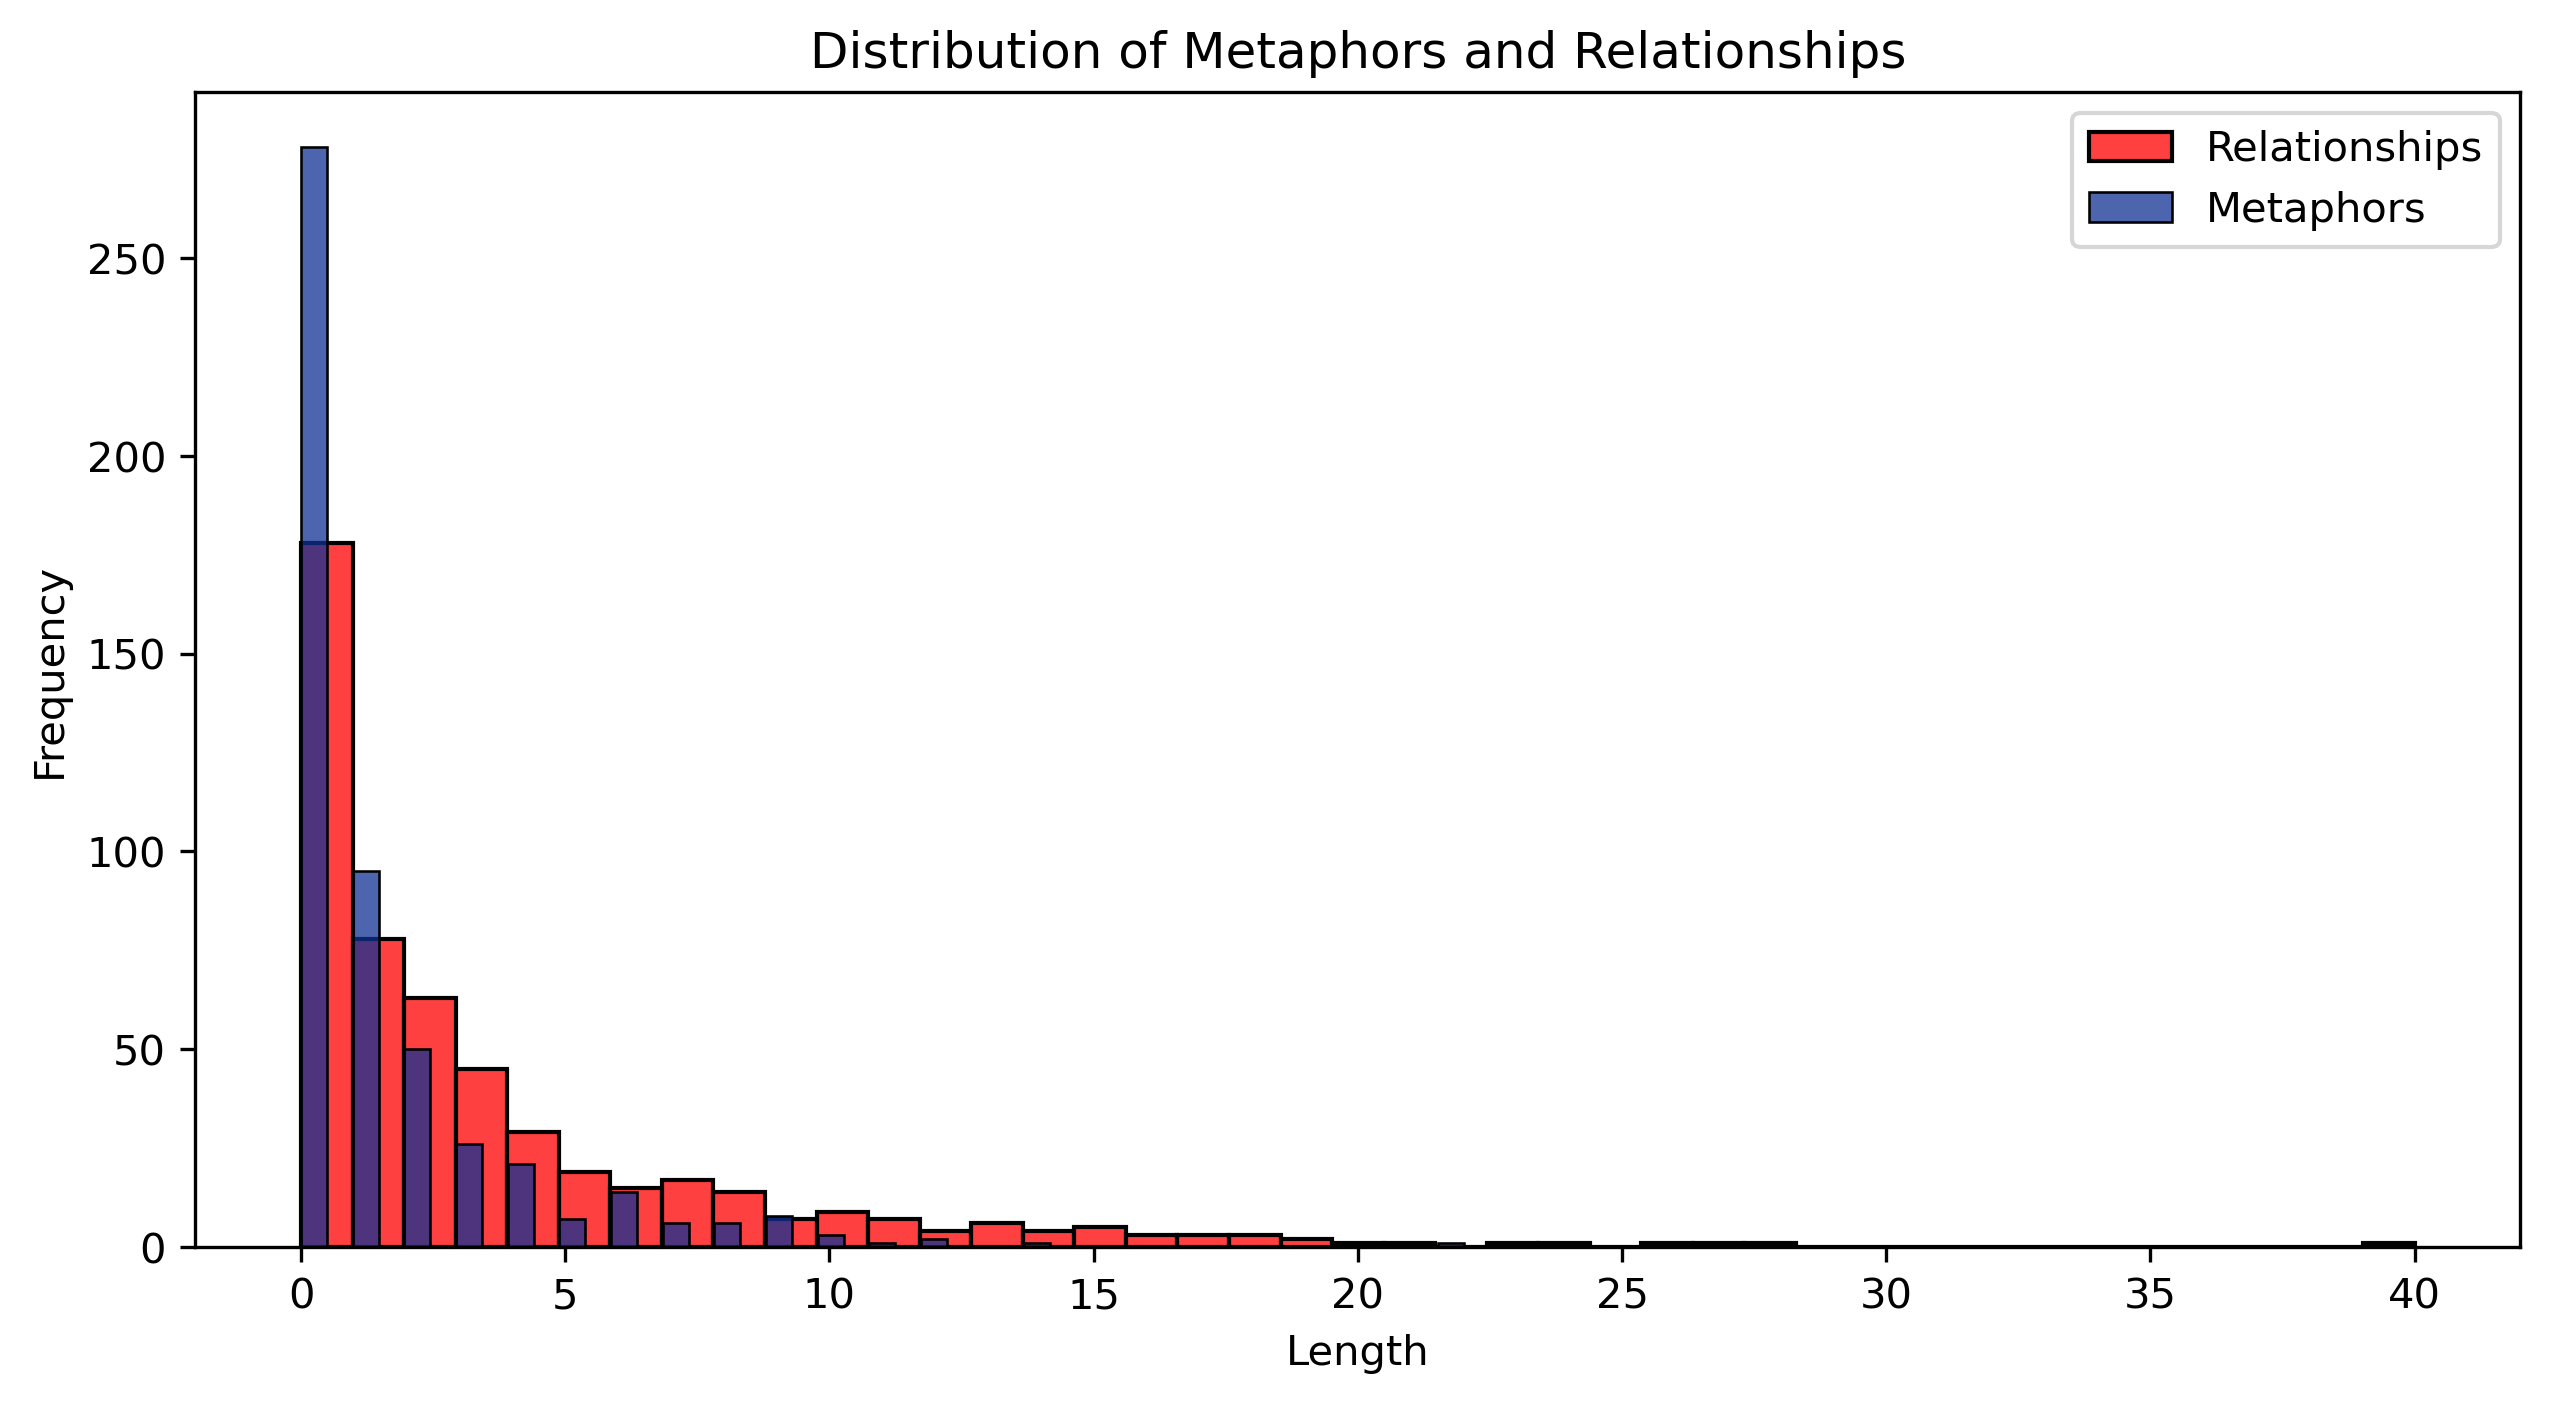

In [27]:
# Plot the length distribution from both columns
plt.figure(figsize=(10, 5), dpi=300)
sns.histplot(data=df, x='pos_relationships_len', color='red', label='Relationships')
sns.histplot(data=df, x='pos_metaphors_len', color=color, label='Metaphors')
plt.title('Distribution of Metaphors and Relationships')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

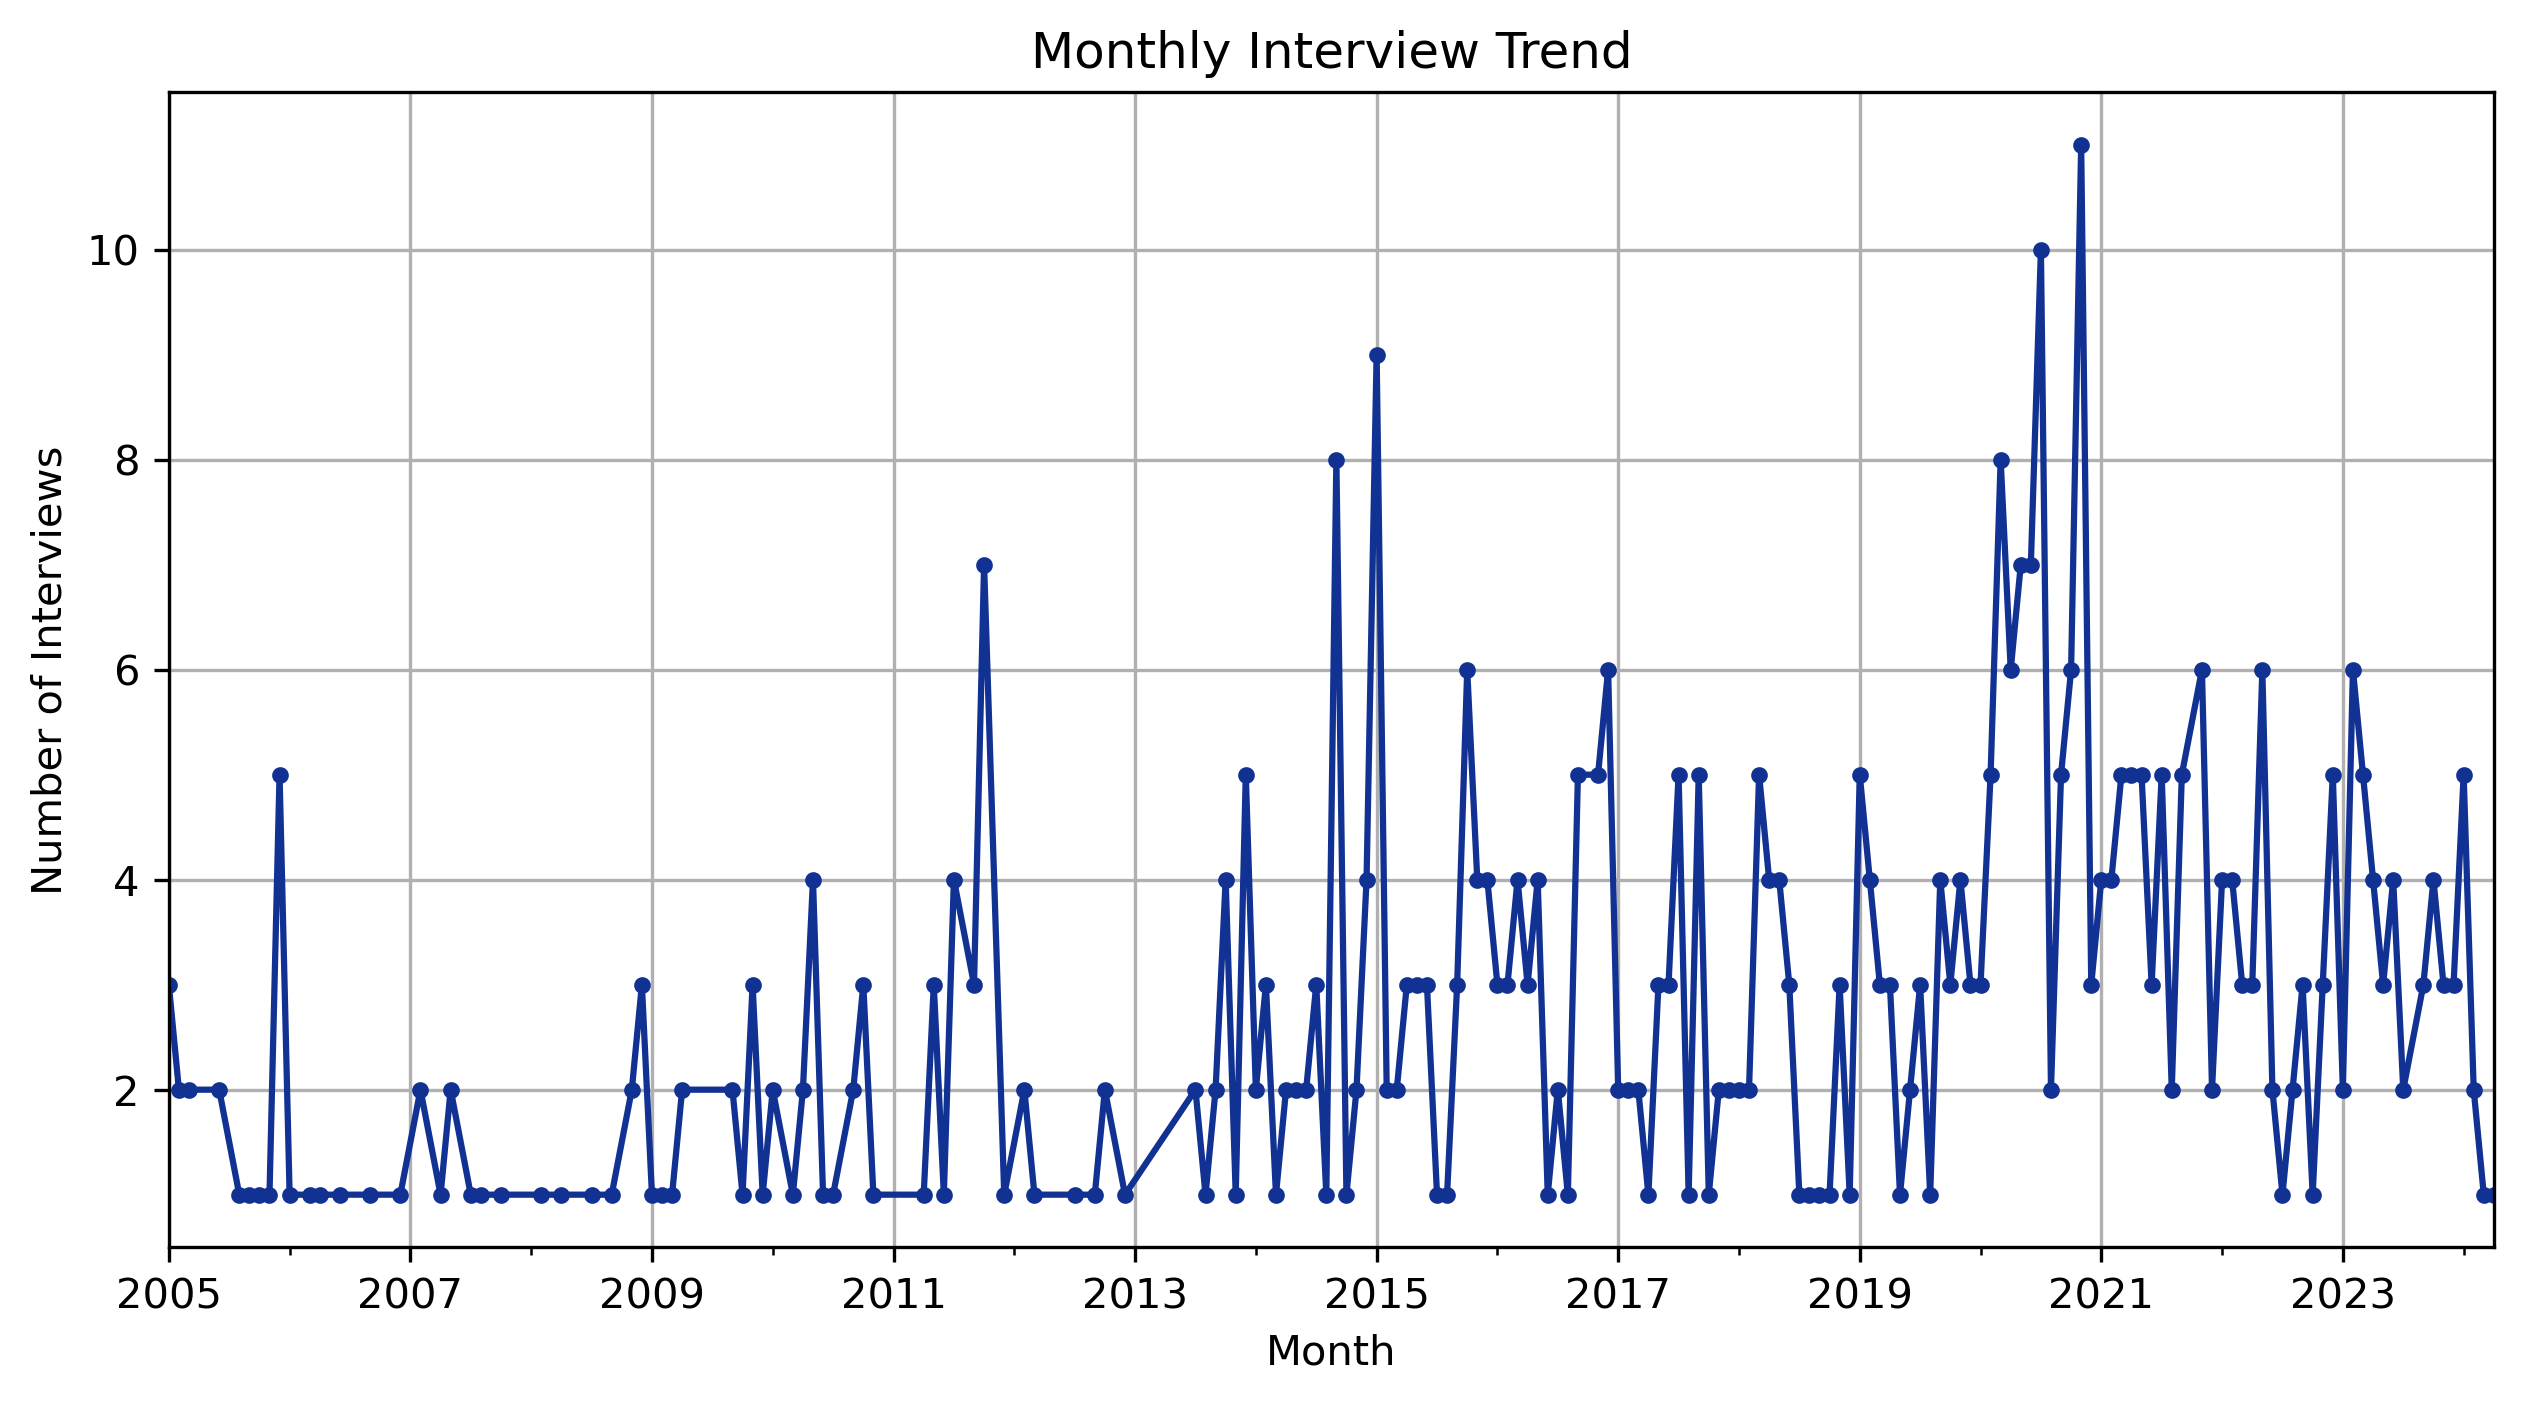

In [28]:
def trend_analysis(df):
    # Group by Year-Month and count entries
    trend_data = df.groupby(df['Date'].dt.to_period('M')).size()
    return trend_data

# Apply the function
monthly_trends = trend_analysis(df)

# Plotting the trend
plt.figure(figsize=(10, 5), dpi=300)
monthly_trends.plot(kind='line', marker='.', title='Monthly Interview Trend', color=color)
plt.xlabel('Month')
plt.ylabel('Number of Interviews')
plt.grid(True)
plt.show()

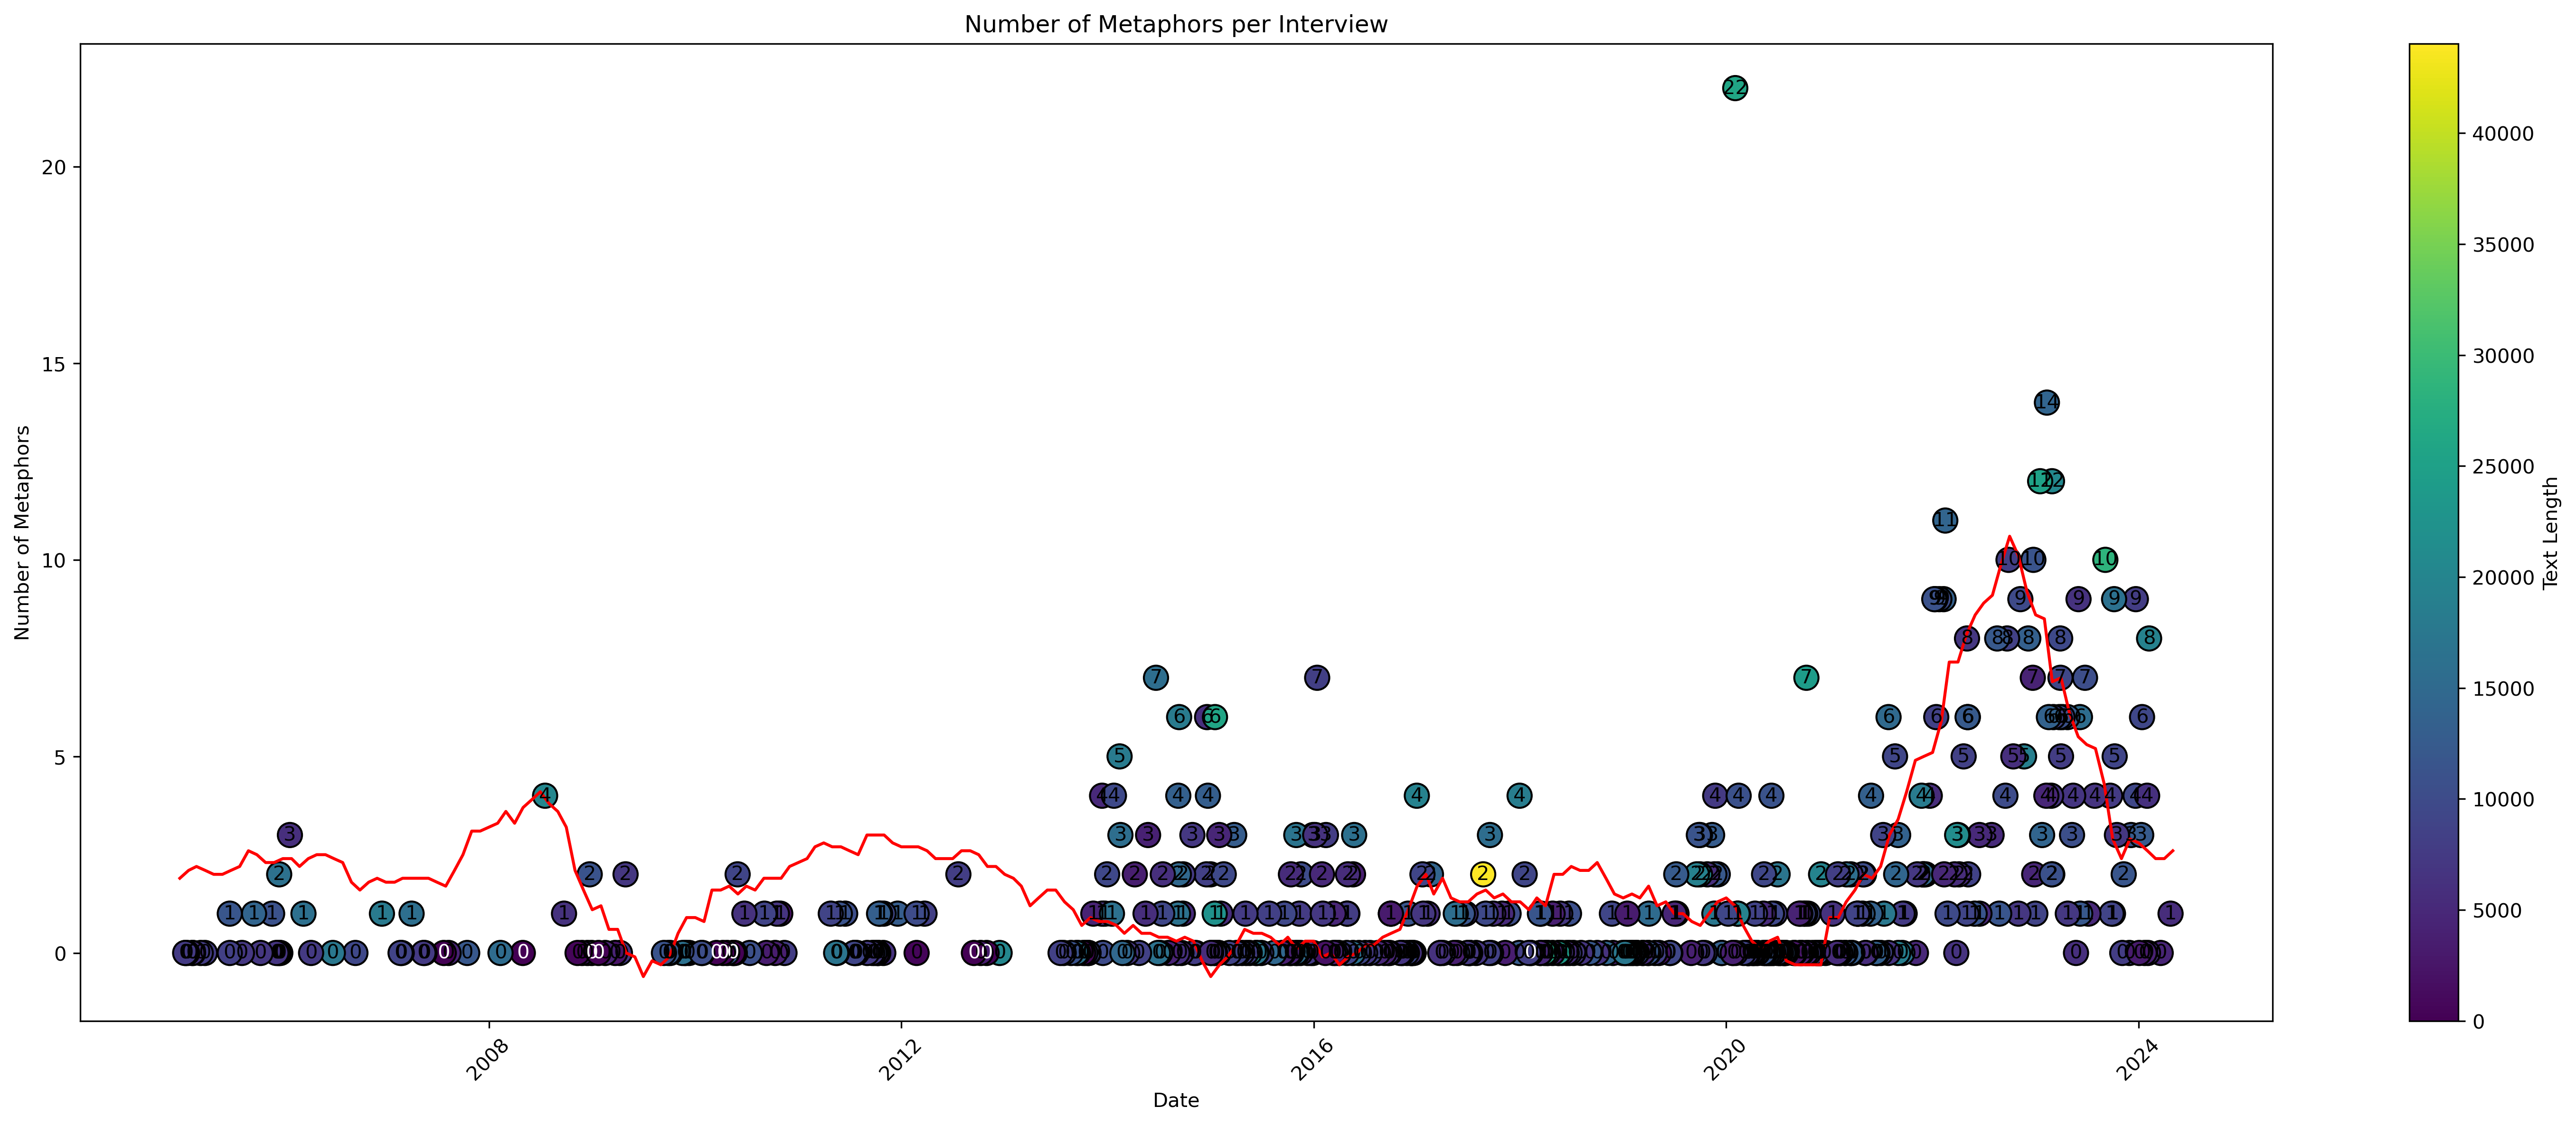

In [31]:
# Defining colors based on text length
norm = mcolors.Normalize(vmin=df['text_length'].min(), vmax=df['text_length'].max())
cmap = plt.cm.get_cmap('viridis')

# Create figure and axes
fig, ax = plt.subplots(figsize=(20, 8), dpi=300)

# Create scatter plot
sc = ax.scatter(df['Date'], df['pos_metaphors_len'], c=df['text_length'], cmap=cmap, norm=norm, s=150, edgecolors='k')

# Add text length colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(df['text_length'])  # Set array to be the range of the colormap
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Text Length')

# Add metaphor count labels inside the points
for i, row in df.iterrows():
    ax.text(row['Date'], row['pos_metaphors_len'], str(row['pos_metaphors_len']), ha='center', va='center', color='white' if row['text_length'] < 0.5 else 'black')

# Plot line for OBS_VALUE from df2
ax.plot(df2['TIME_PERIOD'], df2['OBS_VALUE'], color='red', label='OBS_VALUE')

# Set plot labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Number of Metaphors')
ax.set_title('Number of Metaphors per Interview')

# Rotate x-axis labels for better readability
ax.tick_params(axis='x', rotation=45)

# Show plot
plt.tight_layout()
plt.show()